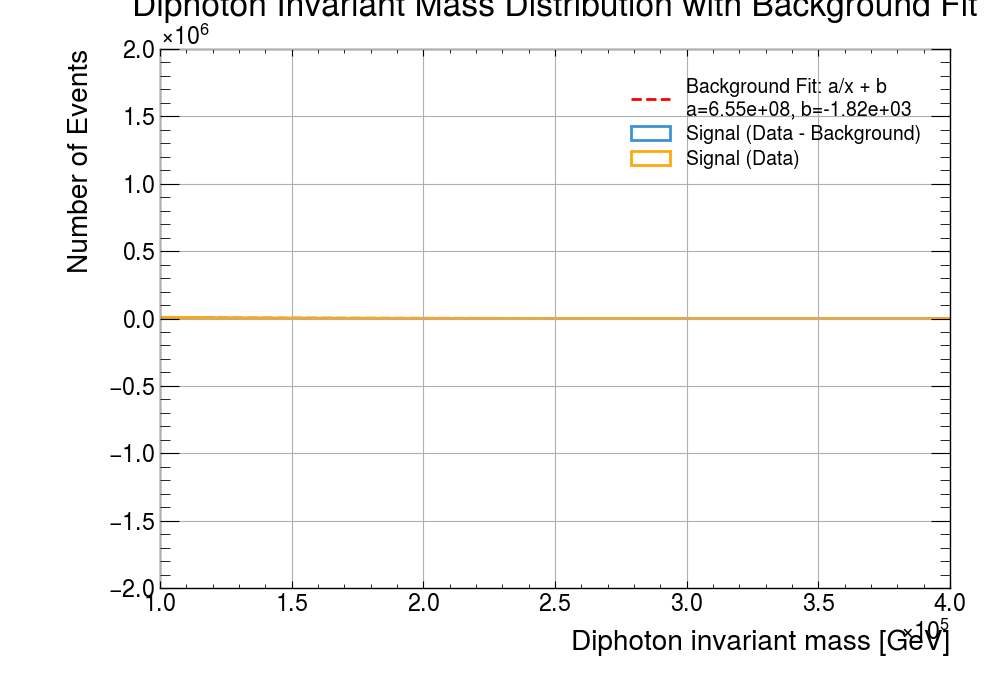

In [11]:
%matplotlib widget
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
import vector

# Load the ROOT file and the tree
file = uproot.open("GamGam/Data/data_B.GamGam.root")  # replace with the correct path
tree = file["mini"]

#V:\Programme\Higgs\GamGam\Data\data_B.GamGam.root

# Extract photon transverse momentum, eta, and phi
photon_pt = tree["photon_pt"].array(library="np")
photon_eta = tree["photon_eta"].array(library="np")
photon_phi = tree["photon_phi"].array(library="np")
photon_E = tree["photon_E"].array(library="np")

# Prepare an array for storing the invariant masses
masses = []

for event in range(len(photon_pt)):
    sorted_indices = np.argsort(photon_pt[event])[::-1]  # Sort photon transverse momenta in descending order
    if len(sorted_indices) >= 2:  # Ensure there are at least two photons
        # Get the highest and second highest transverse momentum photons
        pt1, pt2 = photon_pt[event][sorted_indices[0]], photon_pt[event][sorted_indices[1]]
        eta1, eta2 = photon_eta[event][sorted_indices[0]], photon_eta[event][sorted_indices[1]]
        phi1, phi2 = photon_phi[event][sorted_indices[0]], photon_phi[event][sorted_indices[1]]
        E1, E2 = photon_E[event][sorted_indices[0]], photon_E[event][sorted_indices[1]]

        # Create four-momentum vectors for the two photons using transverse momentum
        photon1 = vector.obj(px=pt1 * np.cos(phi1), py=pt1 * np.sin(phi1), pz=pt1 * np.sinh(eta1), E=E1)
        photon2 = vector.obj(px=pt2 * np.cos(phi2), py=pt2 * np.sin(phi2), pz=pt2 * np.sinh(eta2), E=E2)
        
        # Calculate the invariant mass
        mass = (photon1 + photon2).mass
        masses.append(mass)

# Plotting the invariant mass distribution
plt.figure(figsize=(10, 7))
hist, bins, _ = plt.hist(masses, bins=5000, histtype='step', linewidth=2, label="Data")
bin_centers = (bins[:-1] + bins[1:]) / 2

# Define the function for background fitting
def antipropotional(x, a, b):
    return a * (1 / x) + b

# Select the background region (example: below 115 GeV)
background_region = (1.5e5 < bin_centers) & (bin_centers < 4e5)  # Adjust this range based on your data
background_x = bin_centers[background_region]
background_y = hist[background_region]

# Check for zeros or negative values
background_y = np.maximum(background_y, 1e-10)  # Replace zero or negative values to avoid log issues

# Estimate initial parameters
initial_a = 1e6
initial_b = -0.0001  # A small negative value as a reasonable guess for the decay constant

# Perform the fit with boundsSS
popt, pcov = curve_fit(antipropotional, background_x, background_y, p0=(initial_a, initial_b))

# Generate the fitted background curve over the entire range
background_fit = antipropotional(bin_centers, *popt)

# Subtract the background from the data
signal_hist = hist - background_fit

plt.clf()

# Plot the results
plt.plot(bin_centers, background_fit, 'r--', label=f"Background Fit: a/x + b\na={popt[0]:.2e}, b={popt[1]:.2e}")
plt.hist(bin_centers, bins=bins, weights=signal_hist, histtype='step', linewidth=2, label="Signal (Data - Background)")
plt.hist(bin_centers, bins=bins, weights=hist, histtype='step', linewidth=2, label="Signal (Data)")
plt.xlabel("Diphoton invariant mass [GeV]")
plt.ylabel("Number of Events")
plt.title("Diphoton Invariant Mass Distribution with Background Fit")
plt.xlim(1e5, 4e5)
plt.legend()
plt.grid(True)
hep.style.use("ATLAS")  # Use ATLAS style for the plot
plt.show()
